In [1]:
from tqdm import tqdm

import os
from dotenv import load_dotenv
from datasets import load_dataset

load_dotenv()
tqdm.pandas()
import pandas as pd
import ast
import re
import torch
import torch.nn.functional as F
from dataset_utils import *
from emotion_tree import get_distance
import sys

sys.path.append("..")
from config import *

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

/home/ossamaak0/miniconda3/envs/main/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
print(get_distance(["joy", "desire"], ["excitement", "optimism", "joy"]))
print(get_distance(["joy", "desire"], ["excitement", "optimism"]))
# print(get_distance(["joy", "desire"], ["remorse"]))

1.7692307692307692
1.2307692307692306


In [29]:
print(get_distance(["joy", "desire"], ["joy", "excitement", "optimism", "admiration"]))
print(get_distance(["joy", "desire"], ["remorse"]))

2.846153846153846
1.5384615384615385


# Loading Dataset

In [2]:
dataset = load_dataset("go_emotions", "simplified")
dataset.set_format(type="pandas")
df_train = dataset["train"][:]
df_train = df_train.drop(columns=["id"])

int2label = lambda x: dataset["train"].features["labels"].feature.int2str(x)
df_train["labels_text"] = df_train["labels"].apply(int2label)

In [3]:
# samples = df_train[df_train["ds_emotions"].apply(lambda x: "neutral" in x)]
samples = df_train.sample(50, random_state=RANDOM_SEED)

# LLM Labeling

In [4]:
SYSTEM_MESSAGE = "You're an AI expert trained to analyze and categorize emotions present in text. Your goal is to analyze each piece of text according to instructions"

PROMPT_TEMPLATE = f"""
Given: {{comment}}
Emotion list: {EMOTIONS}

admiration Finding something impressive or
worthy of respect.
amusement Finding something funny or being
entertained.
anger A strong feeling of displeasure or antagonism.
annoyance Mild anger, irritation.
approval Having or expressing a favorable opinion.
caring Displaying kindness and concern for others.
confusion Lack of understanding, uncertainty.
curiosity A strong desire to know or learn something.
desire A strong feeling of wanting something or
wishing for something to happen.
disappointment Sadness or displeasure caused by
the nonfulfillment of one’s hopes or expectations.
disapproval Having or expressing an unfavorable
opinion.
disgust Revulsion or strong disapproval aroused
by something unpleasant or offensive.
embarrassment Self-consciousness, shame, or
awkwardness.
excitement Feeling of great enthusiasm and eagerness.
fear Being afraid or worried.
gratitude A feeling of thankfulness and appreciation.
grief Intense sorrow, especially caused by someone’s
death.
joy A feeling of pleasure and happiness.
love A strong positive emotion of regard and
affection.
nervousness Apprehension, worry, anxiety.
optimism Hopefulness and confidence about
the future or the success of something.
pride Pleasure or satisfaction due to ones own
achievements or the achievements of those with
whom one is closely associated.
realization Becoming aware of something.
relief Reassurance and relaxation following release
from anxiety or distress.
remorse Regret or guilty feeling.
sadness Emotional pain, sorrow.
surprise Feeling astonished, startled by something
unexpected.

Perform an emotional analysis of the comment to by following these steps:

Literal analysis: Identify emotions directly expressed through obvious emotional words/phrases.
Contextual analysis: Consider the full context and implications to detect any additional underlying emotions.
Tonal analysis: Examine tone, subtext, and nuanced emotional cues beyond the literal language.

You may only pick one class, if it's not representitive of the text, you may pick up to 3 classes.

For each level of analysis, provide your findings.
Then, summarize by listing the emotion class(es) that apply in <answer> (classes) </answer>.
"""


final_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYSTEM_MESSAGE),
        # few_shot_prompt,
        ("human", PROMPT_TEMPLATE),
    ]
)

In [5]:
providers_api_base = {
    "ollama": "http://localhost:11434/v1",
    # models in https://fireworks.ai/models
    "fireworks": "https://api.fireworks.ai/inference/v1",
    # models in https://console.groq.com/docs/models
    "groq": "https://api.groq.com/openai/v1",
    # models in https://platform.openai.com/docs/models
    "openai": "https://api.openai.com/v1",
}

In [6]:
model_name = "accounts/fireworks/models/llama-v3-70b-instruct"
provider = "fireworks"
TEMPERATURE = 0.5

# Define models
chat = ChatOpenAI(
    temperature=TEMPERATURE,
    model_name=model_name,
    openai_api_base=providers_api_base[provider],
    openai_api_key=os.environ[provider],
)

chain = final_prompt | chat

In [7]:
samples["predictions"] = None
input_tokens = 0
output_tokens = 0
# for index in range(len(samples)):
for index in tqdm(samples.index):
    comment = samples.loc[index]["text"]
    label = samples.loc[index]["labels_text"]
    response = chain.invoke({"comment": comment})
    content = response.content
    input_tokens += response.response_metadata["token_usage"]["prompt_tokens"]
    output_tokens += response.response_metadata["token_usage"]["completion_tokens"]
    extracted_emotions = extract_emotions(content)
    samples.at[index, "predictions"] = extracted_emotions

input_tokens = input_tokens / len(samples)
output_tokens = output_tokens / len(samples)

100%|██████████| 50/50 [01:34<00:00,  1.88s/it]


# Evaluation

In [28]:
predicted_labels = samples["predictions"]
parsed_output = parse_llama_output(predicted_labels)
parsed_output = [
    filter_invalid_labels(instance, EMOTIONS) for instance in parsed_output
]

In [29]:
GTs = samples["labels_text"].values.tolist()

ImportError: cannot import name 'get_distance' from 'emotion_tree' (/mnt/c/LEGO/Dataset/emotion_tree.py)

In [27]:
for i in range(len(parsed_output)):
    print(samples.iloc[i]["text"])
    print(f"Ground Truth: {GTs[i]} | Predicted: {parsed_output[i]}")
    print(find_shortest_path_list(GTs[i], parsed_output[i]))

The guy just loves drama
Ground Truth: ['love'] | Predicted: ['disapproval', 'annoyance']


TypeError: find_shortest_path_list() missing 1 required positional argument: 'emotions2'

Results for llama-v3-70b-instruct:
Average BCE Loss: 4.6800
Average F1 Score: 0.2307
Average Precision: 0.2360
Average Recall: 0.3663
Average Accuracy: 0.0200


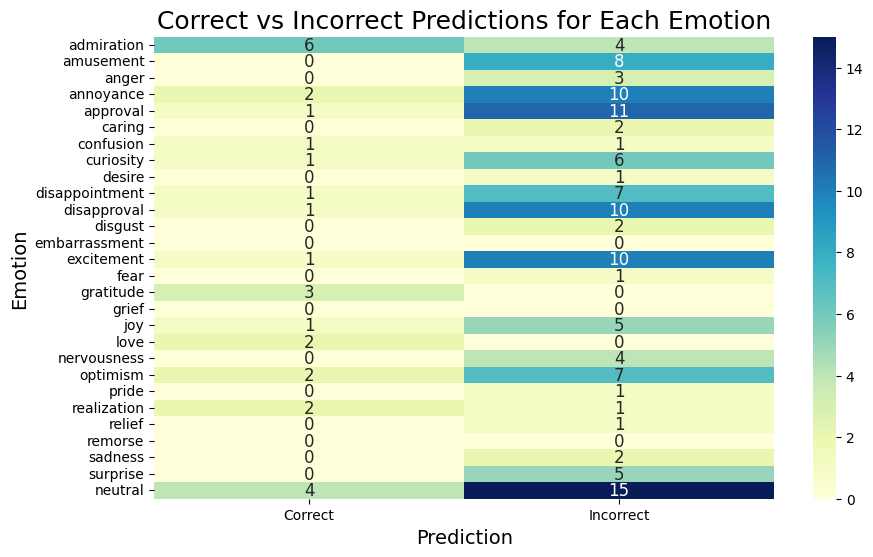

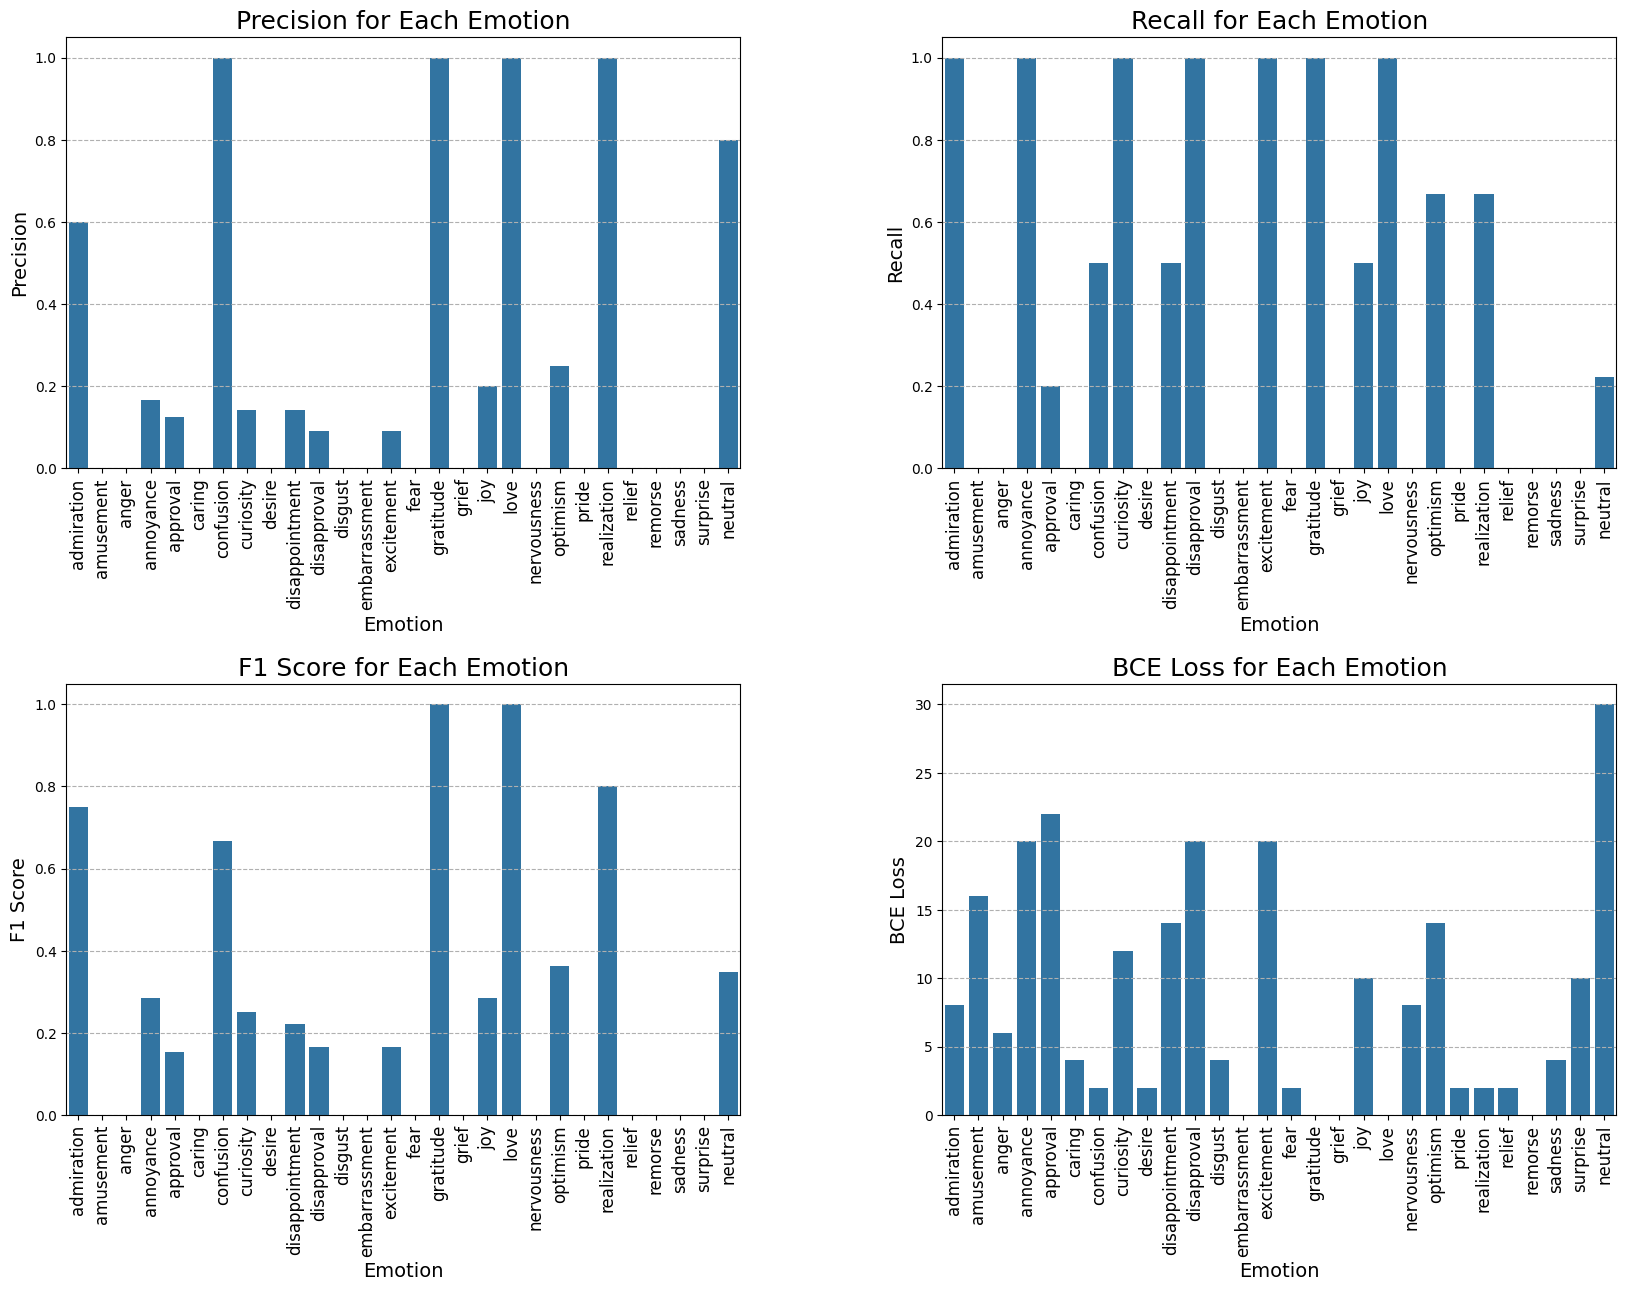

In [21]:
kwargs = {
    # Default Kwargs
    "provider": provider,
    "temperature": TEMPERATURE,
    "avg_input_tokens": input_tokens,
    "avg_output_tokens": output_tokens,
    # Additional Kwargs
    "ensemble": 1,
}


process_save_results(
    model_name.split("/")[-1],
    SYSTEM_MESSAGE,
    PROMPT_TEMPLATE,
    predicted_labels,
    samples["labels_text"],
    EMOTIONS,
    verbose=True,
    trial_num=1,
    **kwargs,
)

In [22]:
samples.to_csv("test.csv", index=False)